In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# --------- 1️⃣ Load Image Paths & Labels from Google Drive ---------
# Define folders
lesion_folder = "/content/drive/MyDrive/ Discipline-specific/1st model /Lesion PreProcessed"
normal_folder = "/content/drive/MyDrive/ Discipline-specific/1st model /New Normal PreProcessed"

# Verify existence of folders
if not os.path.exists(lesion_folder):
    raise FileNotFoundError(f"Folder not found: {lesion_folder}")
if not os.path.exists(normal_folder):
    raise FileNotFoundError(f"Folder not found: {normal_folder}")

# Load image paths and labels
def load_images_from_folder(folder, label):
    """Load image paths with corresponding labels."""
    return [(os.path.join(folder, img), label) for img in os.listdir(folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

# Assign labels (1 = lesion, 0 = normal)
lesion_images = load_images_from_folder(lesion_folder, 1)
normal_images = load_images_from_folder(normal_folder, 0)

# Combine, shuffle, and split dataset
all_images = lesion_images + normal_images
random.seed(42)
random.shuffle(all_images)
image_paths, labels = zip(*all_images)

labels = np.array(labels)  # Convert labels to NumPy array

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# --------- 2️⃣ Preprocess Images & Create Data Pipelines ---------
def preprocess_image(image_path):
    """Read, decode, resize, and normalize an image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Match VGG16 input size
    image = image / 255.0  # Normalize pixel values
    return image

def load_data(image_paths, labels):
    """Create TensorFlow dataset from image paths & labels."""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = load_data(X_train, y_train).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

# --------- 3️⃣ Build Transfer Learning Model (VGG16) ---------
# Load pre-trained VGG16 model (without top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional base

# Build new model with additional layers
def create_model():
    model = models.Sequential([
        base_model,  # Pre-trained VGG16 model

        layers.Flatten(),
        layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),  # Prevent overfitting
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Compile model
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --------- 4️⃣ Train the Model with Early Stopping ---------
class_weights = {0: 1.0, 1: 3.0}  # More weight for lesion class

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=test_dataset,
                    class_weight=class_weights,
                    callbacks=[early_stopping])

# --------- 5️⃣ Evaluate and Save Model ---------
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

# Save model to Google Drive
model_save_path = '/content/drive/MyDrive/skin_classification_model_vgg16.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.6510 - loss: 5.8166 - val_accuracy: 0.9872 - val_loss: 0.4395
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.9800 - loss: 0.4547 - val_accuracy: 0.9949 - val_loss: 0.3194
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9875 - loss: 0.3380 - val_accuracy: 0.9974 - val_loss: 0.2655
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.9913 - loss: 0.2752 - val_accuracy: 0.9949 - val_loss: 0.2264
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.9961 - loss: 0.2268 - val_accuracy: 0.9974 - val_loss: 0.1974
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.9936 - loss: 0.2020 - val_accuracy: 1.0000 - val_loss: 0.1783
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9965 - loss: 0.1755 - val_accuracy: 1.0000 - val_loss: 0.1621
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/


Test accuracy: 1.00

Model saved to: /content/drive/MyDrive/skin_classification_model_vgg16.h5


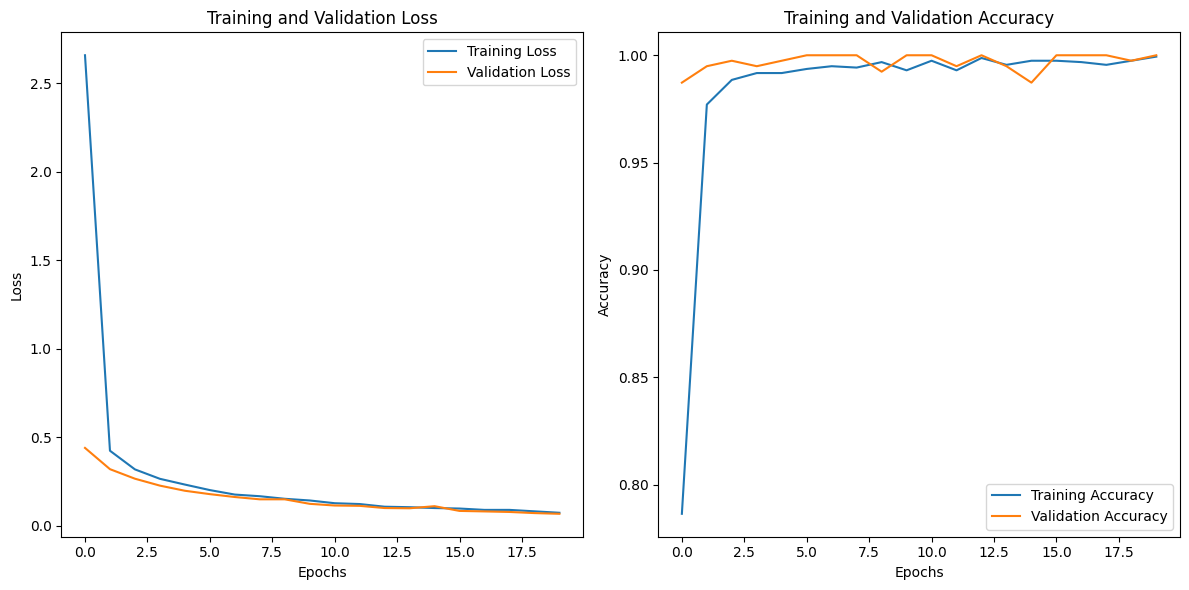

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


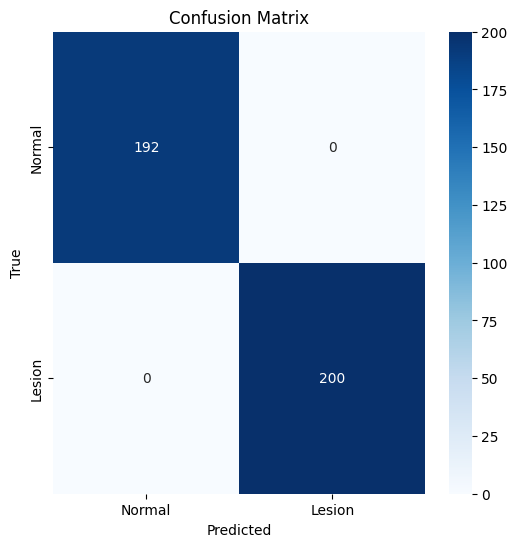

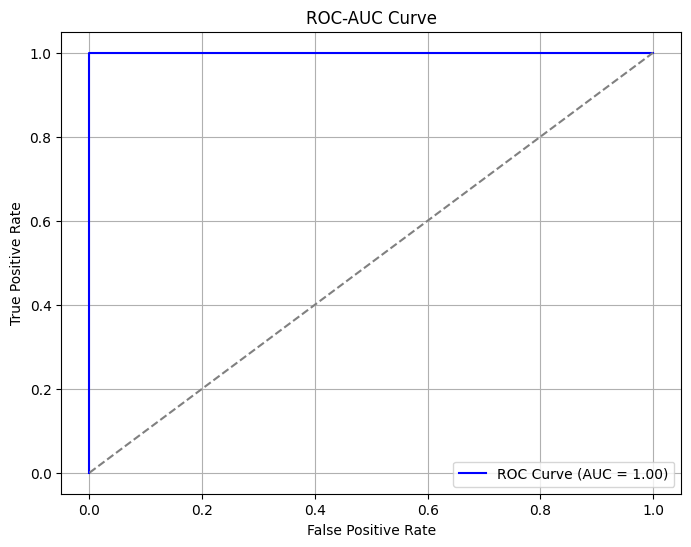


Classification Report:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       192
      Lesion       1.00      1.00      1.00       200

    accuracy                           1.00       392
   macro avg       1.00      1.00      1.00       392
weighted avg       1.00      1.00      1.00       392



In [5]:
import seaborn as sns

def plot_training_history(history):
    """Plots training and validation loss & accuracy."""
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ✅ Generate Predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  # Convert probabilities to binary classes
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

# ✅ Confusion Matrix
def plot_confusion_matrix(y_true, y_pred_classes):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Lesion"], yticklabels=["Normal", "Lesion"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes)

# ✅ ROC-AUC Curve
def plot_roc_auc(y_true, y_pred):
    """Plots the ROC-AUC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # Calculate False Positive Rate and True Positive Rate
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_auc(y_true, y_pred)

# ✅ Classification Report
def generate_classification_report(y_true, y_pred_classes):
    """Generates a classification report."""
    report = classification_report(y_true, y_pred_classes, target_names=["Normal", "Lesion"])
    print("\nClassification Report:\n")
    print(report)

generate_classification_report(y_true, y_pred_classes)